<a href="https://colab.research.google.com/github/prateekchandrajha/mastering-ml-algorithms/blob/main/Coding_ML_Algos_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from numpy.random import randn
import random
from IPython.core.display import display,Image
from string import Template
import IPython.display
import warnings

## Linear Regression From Scratch

In [ ]:
class LinearRegression:

  def __init__(self, learning_rate=0.001, n_iters=1000):
    self.lr = learning_rate
    self.n_iters = n_iters
    self.weights = None
    self.bias = None

  def fit(self, X, y):
    n_samples, n_features = X.shape

    # initialize params
    self.weights = np.zeros(n_features)
    self.bias = 0

    # run the gradient descent
    for _ in range(self.n_iters):
      y_predicted = np.dot(X, self.weights) + self.bias
      
      # compute gradients
      dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
      db = (1 / n_samples) * np.sum(y_predicted - y)

      #update params
      self.weights -= self.lr * dw
      self.bias -= self.lr * db

  def predict(self, X):
    y_approximated = np.dot(X, self.weights) + self.bias
    return y_approximated

def mse(y_true, y_pred):
  return np.mean((y_true-y_pred)**2)

X, y = datasets.make_regression(n_samples=100, n_features=1, noise=20, random_state=4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)



In [ ]:
regressor = LinearRegression(learning_rate=0.01, n_iters=1000)

regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)

In [ ]:
mean_s_error = mse(y_test, predictions)

print("MSE:", mean_s_error)

MSE: 305.7719958301902


In [ ]:
y_pred_line = regressor.predict(X)

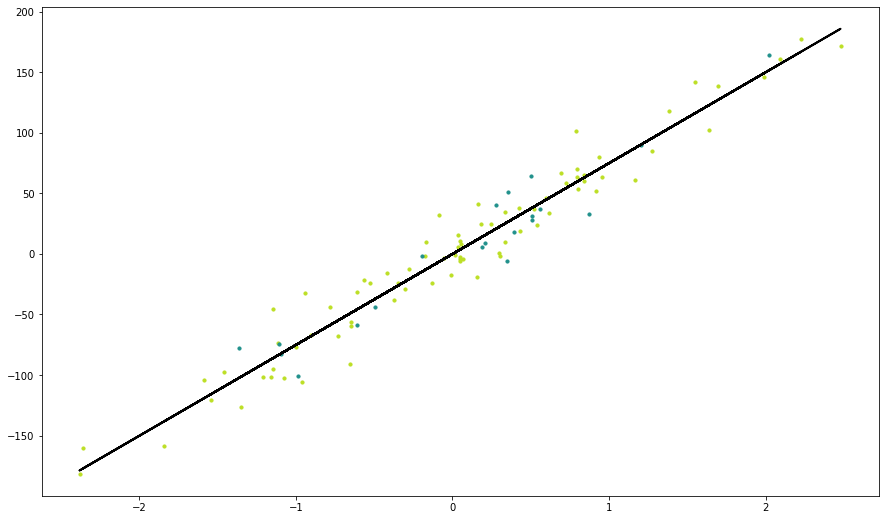

In [ ]:
cmap = plt.get_cmap("viridis")
fig = plt.figure(figsize=(15,9))
m1 = plt.scatter(X_train, y_train, color=cmap(0.9), s=10)
m2 = plt.scatter(X_test, y_test, color = cmap(0.5), s=10)
plt.plot(X, y_pred_line, color="black", linewidth=2, label = "Prediction")
plt.show()

## Decision Tree using CART From Scratch


In [ ]:
from collections import Counter

In [ ]:
def entropy(y):
  hist = np.bincount(y)
  ps = hist / len(y)
  return(-np.sum([p*np.log2(p) for p in ps if p>0]))

In [31]:
class Node:

  def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
    self.feature = feature
    self.threshold = threshold
    self.left = left
    self.right = right
    self.value = value

  def is_leaf_node(self):
    return self.value is not None

class DecisionTree:
  def __init__(self, min_samples_split = 2, max_depth=100, n_feats=None):
    self.min_samples_split = min_samples_split
    self.max_depth = max_depth
    self.n_feats = n_feats
    self.root = None

  def fit(self, X, y):
    self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
    self.root = self._grow_tree(X,y)

  def _grow_tree(self, X, y, depth=0):
    n_samples, n_features = X.shape
    n_labels = len(np.unique(y))

    # setting the stopping criteria

    if depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split:
      leaf_value = self._most_common_label(y)
      return Node(value=leaf_value)

    feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

    # perform a greedy search

    best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
    left_idxs, right_idxs = self._split(X[:,best_feat], best_thresh)

    left = self._grow_tree(X[left_idxs,:], y[left_idxs], depth+1)
    right = self._grow_tree(X[right_idxs,:], y[right_idxs], depth+1)

    return Node(best_feat, best_thresh, left, right)

  def _best_criteria(self, X, y, feat_idxs):
    best_gain = -1
    split_idx, split_thresh = None, None
    for feat_idx in feat_idxs:
      X_column = X[:, feat_idx]
      thresholds = np.unique(X_column)
      for threshold in thresholds:
        gain = self._information_gain(y, X_column, threshold)
        if gain>best_gain:
          best_gain = gain
          split_idx = feat_idx
          split_thresh = threshold
    return(split_idx, split_thresh)

  def _information_gain(self, y, X_column, split_threh):
    parent_entropy = entropy(y)

    # generating splits

    left_idxs, right_idxs = self._split(X_column, split_threh)
    if len(left_idxs)==0 or len(right_idxs)==0:
      return 0

    # calculating weighted average child entropy

    n = len(y)
    n_l, n_r = len(left_idxs), len(right_idxs)
    e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
    child_entropy = (n_l/n)*e_l + (n_r/n)*e_r

    # finally calculate how much information did you gain

    ig = parent_entropy - child_entropy

    return ig

  def _split(self, X_column, split_threh):
    left_idxs = np.argwhere(X_column <= split_threh).flatten()
    right_idxs = np.argwhere(X_column>split_threh).flatten()
    return(left_idxs, right_idxs)

  def predict(self, X):
    return(np.array([self._traverse_tree(x, self.root) for x in X]))

  def _traverse_tree(self, x, node):
    if node.is_leaf_node():
      return node.value 
    
    if x[node.feature]<=node.threshold:
      return self._traverse_tree(x, node.left)

    return self._traverse_tree(x, node.right)

  def _most_common_label(self, y):
    counter =  Counter(y)
    most_common = counter.most_common(1)[0][0]
    return(most_common)


      



In [32]:
def accuracy(y_true, y_pred):
  accuracy = np.sum(y_true==y_pred)/len(y_true)
  return accuracy

In [33]:
data = datasets.load_breast_cancer()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

clf = DecisionTree(max_depth=20)
clf.fit(X_train, y_train)



In [34]:
y_pred = clf.predict(X_test)
acc = accuracy(y_test, y_pred)

print("Accuracy = ", acc)

Accuracy =  0.9385964912280702


In [35]:
y_pred

array([1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 0])

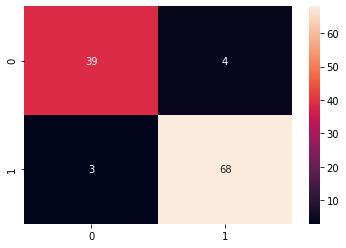

In [36]:
cnf_matrix = confusion_matrix(y_test, y_pred)
import seaborn as sns
sns.heatmap(cnf_matrix, annot=True)

## Implementing Random Forest from Scratch

In [38]:
from tqdm import tqdm

In [40]:
def bootstrap_sample(X,y):
  n_samples = X.shape[0]
  idxs = np.random.choice(n_samples, size = n_samples, replace=True)
  return(X[idxs], y[idxs])

def most_common_label(y):
  counter = Counter(y)
  most_common = counter.most_common(1)[0][0]
  return most_common

class RandomForest:
  def __init__(self, n_trees = 100, min_samples_split = 2, max_depth=100, n_feats=None):
    self.n_trees = n_trees
    self.min_samples_split = min_samples_split
    self.max_depth = max_depth
    self.n_feats = n_feats
    self.trees = []

  def fit(self, X, y):
    self.trees = []
    for _ in tqdm(range(self.n_trees)):
      tree = DecisionTree(min_samples_split=self.min_samples_split, max_depth=self.max_depth, n_feats=self.n_feats)
      X_sample, y_sample = bootstrap_sample(X, y)
      tree.fit(X_sample, y_sample)
      self.trees.append(tree)

  def predict(self, X):
    tree_preds = np.array([tree.predict(X) for tree in self.trees])
    tree_preds = np.swapaxes(tree_preds, 0, 1)
    y_pred = [most_common_label(tree_pred) for tree_pred in tree_preds]
    return np.array(y_pred)

  


In [41]:
clf_f = RandomForest(n_trees=20)
clf_f.fit(X_train, y_train)

y_pred = clf_f.predict(X_test)
acc = accuracy(y_test, y_pred)

print("Random Forest From Scratch Accuracy = ", acc)


100%|██████████| 20/20 [00:53<00:00,  2.65s/it]

Random Forest From Scratch Accuracy =  0.956140350877193


## Naive Bayes / Simplest Bayesian Network Model - Kernel Density Estimation can be added to gain higher accuracy

In [52]:
class NaiveBayes:
  # def __init__(self, )

  def fit(self, X, y):
    n_samples, n_features = X.shape
    self._classes = np.unique(y)
    n_classes = len(self._classes)

    # initialize mean, variance and priors

    self._mean = np.zeros((n_classes,n_features), dtype=np.float64)
    self._var = np.zeros((n_classes, n_features), dtype=np.float64)
    self._priors = np.zeros(n_classes, dtype=np.float64)

    for c in self._classes:
      X_c = X[c==y]
      self._mean[c,:] = X_c.mean(axis=0)
      self._var[c,:] = X_c.var(axis=0)
      self._priors[c] = X_c.shape[0]/float(n_samples)

  def predict(self, X):
    y_pred = [self._predict(x) for x in X] 
    return y_pred

  def _predict(self, x):
    posteriors = []
    for idx, c in enumerate(self._classes):
      prior = np.log(self._priors[idx])
      class_conditional = np.sum(np.log(self._pdf(idx,x)))
      posterior = prior + class_conditional
      posteriors.append(posterior)

      return self._classes[np.argmax(posteriors)]

  def _pdf(self, class_idx, x):
    mean = self._mean[class_idx]
    var = self._var[class_idx]
    numerator = np.exp(-(x-mean)**2/(2*var))
    denominator = np.sqrt(2*np.pi*var)
    return numerator/denominator


In [54]:
class NaiveBayes:

  def fit(self, X, y):
    n_samples, n_features = X.shape
    self._classes = np.unique(y)
    n_classes = len(self._classes)

    #init mean, var, priors
    self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
    self._var = np.zeros((n_classes, n_features), dtype=np.float64)
    self._priors = np.zeros(n_classes, dtype=np.float64)

    for c in self._classes:
      X_c = X[c==y]
      self._mean[c,:]=X_c.mean(axis=0)
      self._var[c,:]=X_c.var(axis=0)
      self._priors[c] = X_c.shape[0] / float(n_samples)

  def predict(self,X):
    y_pred = [self._predict(x) for x in X]
    return(y_pred)
    
  def _predict(self, x):
    posteriors = []
    for idx, c in enumerate(self._classes):
      #print(idx,c)
      prior = np.log(self._priors[idx])
      class_conditional = np.sum(np.log(self._pdf(idx,x)))
      posterior = prior + class_conditional
      posteriors.append(posterior)
    return(self._classes[np.argmax(posteriors)])


    
  def _pdf(self, class_idx, x):
    mean = self._mean[class_idx]
    var = self._var[class_idx]
    numerator = np.exp(-(x-mean)**2/(2 * var))
    denominator = np.sqrt(2*np.pi*var)
    return(numerator/denominator)



In [55]:
def accuracy(y_true, y_pred):
  accuracy = np.sum(y_true == y_pred)/len(y_true)
  return(accuracy)

X,y = datasets.make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=123)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

nb = NaiveBayes()
nb.fit(X_train, y_train)
predictions = nb.predict(X_test)

print("Naive Bayes classification accuracy ",accuracy(y_test, predictions))

Naive Bayes classification accuracy  0.965


In [56]:
predictions

[0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0]

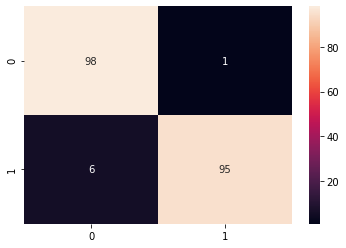

In [58]:
cnf_matrix = confusion_matrix(y_test, predictions)
import seaborn as sns
sns.heatmap(cnf_matrix, annot=True)